In [2]:
import transformers
import datasets
import pandas as pd
import numpy as np

In [3]:
model_checkpoint = "/kaggle/input/huggingfacedebertav3variants/deberta-v3-xsmall"

In [4]:
from datasets import Dataset

In [5]:
df = pd.read_csv('/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv')

In [32]:
not_persuade_df = df[df['source'] != 'persuade_corpus']
persuade_df = df[df['source'] == 'persuade_corpus']
sampled_persuade_df = persuade_df.sample(n=6000, random_state=42)

all_human = set(list(''.join(sampled_persuade_df.text.to_list())))
other = set(list(''.join(not_persuade_df.text.to_list())))
chars_to_remove = ''.join([x for x in other if x not in all_human])
print(chars_to_remove)

translation_table = str.maketrans('', '', chars_to_remove)
def remove_chars(s):
    return s.translate(translation_table)

安💰😵🌽ā😃🦸集💅时🛣🏔🐒👩的道🛀🌨♂♀÷‘📊📱🎮部😩🤗🥜が使🍞😊🛸🛋с👮中こ🍜路🍗ê🥛🏫🤤🎣⚽🕰🧀🥖🎊😆🕺😮🚚🥳📺р🤖🍴📧🧐🇸🏋🙃👥🎧💸👨💬🌈🧽👂す☹ま🎈💨🇯🌸🧬ã😂手📷🔑🤫🏕🌫🐧🗣🍮取🤔🐢🍖🍷💭🐻🏡🎃^🍭🛫🏄🦄�💯🌱🤓都🤪🏞╯ü😴💊🛍有🏢🔍🚔”🙈🥑🐸🌷🤯🌄😭😻😕🥗🥕🐬🏃😷🍰🍲✨🥁💤—😌🐴п─🌟将🚕🛠ち🙅🌊🏊须🐶👌🤛🚑🇺あо禁😍а🚂💔👍驶🙌🏟👏🇧😓和📹🙋🤘🎤🌧🧩止¬🚫💘😘🤕🤞👯🥘机🌯📚と🤦🤣👧🌻🐰😨全🛑🥦🍄😋💥🥶😖…是📸🎹😅💉影🇫🏙🏯🤷🍣🥤🤝み😢合🍕👪😈🐭🎢择😤🎸🍔🍝❄🎾“🐾🍽🗳🎓🍁🧹🏼🧡–🌳з🔋🙏🦎�🤢🚴🎵​°🥨🏏🐕🐝💡🌐😬🥯📦😉保🔧🌅🏈🏛🚨🌞💚🌮📅🤟👀唯🔬🦁🎩🎯一💼🍋🏻🏳🚗🚭👦🏨⏰🚪🙄力💇🥟🌏😱🔭😡驾🎭せ😳😒🎨响í🐦🍿👬🏀🇪🇷ん🔜😹💖👻🏦护💆司🌃🚌🐆💃🥲🧠🐠🚀🥪🙊用


In [33]:
df['text'] = df['text'].apply(remove_chars)
df['text'] = df['text'].str.replace('\n', '')

In [34]:
train = df.loc[df["prompt_name"] != "The Face on Mars"]
test = df.loc[df["prompt_name"] == "The Face on Mars"]

In [49]:
ds_train = Dataset.from_pandas(train)
ds_test = Dataset.from_pandas(test)

In [50]:
ds_train

Dataset({
    features: ['text', 'label', 'prompt_name', 'source', 'RDizzl3_seven', '__index_level_0__'],
    num_rows: 42975
})

In [51]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [52]:
def preprocess_function(examples):
    return tokenizer(examples['text'], max_length=128, padding=True, truncation=True)

In [53]:
ds_train_enc = ds_train.map(preprocess_function, batched=True)

  0%|          | 0/43 [00:00<?, ?ba/s]

In [54]:
ds_test_enc = ds_test.map(preprocess_function, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

In [55]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/huggingfacedebertav3variants/deberta-v3-xsmall and are newly initialized: ['classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
metric_name = "roc_auc"
model_name = "deberta-xsmall"
train_batch_size = 4
eval_batch_size = 32
grad_acc = 4

In [57]:
num_steps = len(train) // (train_batch_size * grad_acc)
num_steps

2685

In [58]:
args = TrainingArguments(
    f"{model_name}-finetuned",
    evaluation_strategy = "steps",
    save_strategy = "steps",
    eval_steps = num_steps // 3,
    save_steps = num_steps // 3,
    learning_rate=2e-5,
    per_device_train_batch_size=train_batch_size,
    per_device_eval_batch_size=eval_batch_size,
    gradient_accumulation_steps=grad_acc,
    num_train_epochs=1,
    weight_decay=0.01,
    load_best_model_at_end=False,
    metric_for_best_model=metric_name,
    report_to='none', # change to wandb after enabling internet access
)

In [59]:
from sklearn.metrics import roc_auc_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)
    auc = roc_auc_score(labels, probs[:,1], multi_class='ovr')
    return {"roc_auc": auc}

In [60]:
trainer = Trainer(
    model,
    args,
    train_dataset=ds_train_enc,
    eval_dataset=ds_test_enc,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [61]:
trainer.train()

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Roc Auc
895,0.123600,0.044687,0.999692
1790,0.031100,0.130395,0.999731
2685,0.028300,0.132089,0.999715


TrainOutput(global_step=2686, training_loss=0.04870335752184677, metrics={'train_runtime': 683.751, 'train_samples_per_second': 62.852, 'train_steps_per_second': 3.928, 'total_flos': 707745491827200.0, 'train_loss': 0.04870335752184677, 'epoch': 1.0})

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics

In [67]:
eval_result = trainer.evaluate(ds_test_enc)

In [69]:
pred_result = trainer.predict(ds_test_enc)

In [70]:
ds_test_enc.shape

(1893, 9)

In [74]:
test_enc = pd.DataFrame(ds_test_enc)

In [75]:
test_enc["label"]

0       0
1       0
2       0
3       0
4       0
       ..
1888    1
1889    1
1890    1
1891    1
1892    1
Name: label, Length: 1893, dtype: int64

In [88]:
pred_result.predictions[:,0].shape

(1893,)

In [95]:
from sklearn.metrics import roc_curve,confusion_matrix,auc
def roc_curve_plot(fpr,tpr,roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' %roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Transformer ROC')
    plt.legend(loc="lower right")
    plt.show()

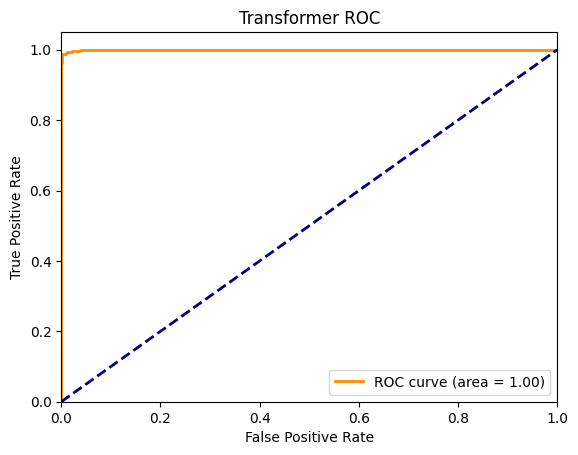

In [96]:
fpr, tpr, _ = roc_curve(test_enc["label"],pred_result.predictions[:,1])
roc_auc = auc(fpr, tpr)
roc_curve_plot(fpr,tpr,roc_auc)

In [46]:
# submission = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
# submission_ds = Dataset.from_pandas(test)
# submission_ds_enc = test_ds.map(preprocess_function, batched=True)
# submission_preds = trainer.predict(submission_ds_enc)

In [48]:
# logits = submission_preds.predictions
# probs = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)
# sub = pd.DataFrame()
# sub['id'] = test['id']
# sub['generated'] = probs[:,1]
# sub.to_csv('submission.csv', index=False)
# sub.head()

In [30]:
res = []
for src in valid.source.unique():
    if src in ['train_essays', 'persuade_corpus', 'original_moth']: continue
    test2  = valid[valid['source'].isin([src, 'train_essays'])]
    test_ds2 = Dataset.from_pandas(test2)
    test_ds_enc2 = test_ds2.map(preprocess_function, batched=True)
    eval_result = trainer.evaluate(test_ds_enc2)
    score = eval_result['eval_roc_auc']
    res.append(f'{src}: {score}')
    
for r in res: print(r)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

mistral7binstruct_v2: 0.9720650636492221
llama_70b_v1: 0.995820330332353
darragh_claude_v7: 0.9905516265912306
radek_500: 0.9981854759181097
darragh_claude_v6: 0.9903732355742862
falcon_180b_v1: 0.9953603185614285
mistral7binstruct_v1: 0.9677712669226106
chat_gpt_moth: 0.9652921336089653
llama2_chat: 0.9596245338819596
NousResearch/Llama-2-7b-chat-hf: 0.9961613432132126
mistralai/Mistral-7B-Instruct-v0.1: 0.9974257425742574
palm-text-bison1: 0.9904667609618105
cohere-command: 0.99012729844413
radekgpt4: 0.9951755430139901
kingki19_palm: 0.998764112035327
